#Config

In [0]:
!pip install transformers==2.6.0

     |████████████████████████████████| 542kB 8.6MB/s 
     |████████████████████████████████| 1.1MB 23.8MB/s 
     |████████████████████████████████| 3.7MB 49.1MB/s 
     |████████████████████████████████| 890kB 53.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=10f679cec6ba7256be42fbca98c047715d7bddc041f614ffe5a541426c471811
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [0]:
!pip install fairseq

     |████████████████████████████████| 307kB 8.4MB/s 
     |████████████████████████████████| 61kB 7.8MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2035346 sha256=2f7874511b5b89a6c2a07325026682b1c762ae62ff87d8316baaced74d5e9d62
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
Successfully built fairseq


In [0]:
!pip install fastBPE

  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp36-cp36m-linux_x86_64.whl size=479270 sha256=bd9941fd1595ee7bd2210118bffffa366e9f2fe97fda5c175c83faa9bcd30097
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
Successfully built fastBPE


In [0]:
!pip install seqeval

  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=bdc54cad614a54107868724e1476f29c8ce9d60bc215ba355fd7b18dbbc55065
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
Successfully built seqeval


In [0]:
import torch
import argparse
import numpy as np
import matplotlib.pyplot as plt
import transformers
import pandas as pd

from torch import nn
from torch.utils.data import DataLoader, RandomSampler, TensorDataset, SequentialSampler

from fairseq.data.encoders.fastbpe import fastBPE
from fairseq.data import Dictionary

from transformers import RobertaConfig, RobertaModel
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange
from seqeval.metrics import f1_score

Using TensorFlow backend.


In [0]:
MAX_LEN = 60
batch_sz = 16
epochs = 5
max_grad_norm = 1.0

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
print('{}: {}'.format(device, n_gpu))

cuda: 1


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Load Data


**Read Data**

In [0]:
data = pd.read_csv('/content/drive/My Drive/data/ner_product_bio.csv', header=None,
                   sep='\t', encoding='utf8', names=['Sentence#', 'Word', 'Tag'])
data.head(10)

,Sentence#,Word,Tag
0,1,Nhưng,O
1,1,hiện_tại,O
2,1,bạn,O
3,1,đang,O
4,1,cho,O
5,1,bé,O
6,1,bú,O
7,1,nên,O
8,1,bạn,O
9,1,không,O


In [0]:
tuple_func = lambda f: [(w, t) for w, t in zip(f['Word'].values, f['Tag'].values)]
sentences_with_tag = data.groupby('Sentence#').apply(tuple_func)
print(sentences_with_tag)
sentences_with_tag = [sent for sent in sentences_with_tag]

Sentence#
1       [(Nhưng, O), (hiện_tại, O), (bạn, O), (đang, O...
2                        [(Áo, B-pr), (Hm, I-pr), (ạ, O)]
3       [(Cho, O), (mình, O), (đặt, O), (cái, O), (bal...
4       [(Ac, O), (có, O), (vest, B-pr), (chưa, O), (?...
5       [(body, B-pr), (lotion, I-pr), (e, O), (lại, O...
                              ...                        
2091    [(Dạ, O), (trước, O), (em, O), (có, O), (dùng,...
2092    [(_son, B-pr), (black, I-pr), (rouge, I-pr), (...
2093    [(da, O), (nươc, I-pr), (hoa, I-pr), (foellie,...
2094    [(Hiện, O), (bên, O), (Hương, O), (đang, O), (...
2095    [(Kem, B-pr), (dưỡng, I-pr), (ban_đêm, I-pr), ...
Length: 2095, dtype: object


In [0]:
sentences = [' '.join([word[0] for word in sent]) for sent in sentences_with_tag]
sentences[1]

'Áo Hm ạ'

In [0]:
labels = [[word[1] for word in sent] for sent in sentences_with_tag]
labels[1]

['B-pr', 'I-pr', 'O']

In [0]:
labels_value = ['B-pr','I-pr','O', 'PAD', '[CLS]', '[SEP]', 'X']
label2idx = {label:indx for indx, label in enumerate(labels_value)}
label2idx

{'B-pr': 0, 'I-pr': 1, 'O': 2, 'PAD': 3, 'X': 6, '[CLS]': 4, '[SEP]': 5}

***Encode with bpe***

In [0]:
parser = argparse.ArgumentParser()
parser.add_argument('--bpe-codes', 
    default="/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/bpe.codes",
    required=False,
    type=str,  
    help='path to fastBPE BPE'
)
args, unknown = parser.parse_known_args()

bpe = fastBPE(args)

In [0]:
subwords = ['<s> '+bpe.encode(sent)+' </s>' for sent in sentences]
subwords[1] 

'<s> Áo H@@ m ạ </s>'

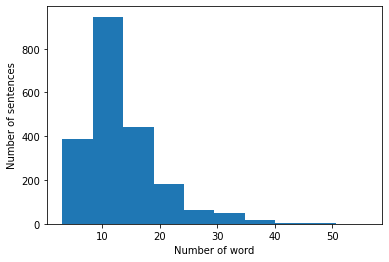

In [0]:
plt.hist([len(s.split()) for s in subwords])
plt.xlabel('Number of word')
plt.ylabel('Number of sentences')
plt.show()

***Change labels by subword***

In [0]:
# Đánh label X cho những từ là subword, thêm label [CLS], [SEP] 
"""
Câu gốc:
  Áo Hm ạ --> ['B-pr', 'I-pr', 'O']
Câu sau khi encode:
  <s> Áo H@@ m ạ </s> --> ['[CLS]', 'B-pr', 'X', 'I-pr', 'O', '[SEP]']
""" 
label_subwords = []
for i in range(len(subwords)):
  indx = 0
  label = ['[CLS]']
  for word in subwords[i].split()[1:MAX_LEN-1]:
    if word == '</s>':
      break
    if '@@' not in word:
      label.append(labels[i][indx])
      indx += 1
      continue
    label.append('X')
  label.append('[SEP]')
  label_subwords.append(label) 

In [0]:
label_subwords[1]

['[CLS]', 'B-pr', 'X', 'I-pr', 'O', '[SEP]']

***String to number***

In [0]:
vocab = Dictionary()
vocab.add_from_file("/content/drive/My Drive/pre_model/phobert/PhoBERT_large_transformers/dict.txt")

In [0]:
input_ids = pad_sequences([vocab.encode_line(sent, append_eos=False, add_if_not_exist=False).long().tolist() for sent in subwords],
                          truncating='post', padding='post', maxlen=MAX_LEN, value=1.0, dtype='long')

In [0]:
input_ids[1]

array([   0, 3759, 1125,  599, 3628,    2,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,    1,    1,    1,    1])

In [0]:
labels_ids = pad_sequences([[label2idx.get(label) for label in labels] for labels in label_subwords], dtype='long',
                            maxlen=MAX_LEN, value=label2idx['PAD'], truncating='post', padding='post')
labels_ids[1]

array([4, 0, 6, 1, 2, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [0]:
attenion_mask = [[float(val != 1) for val in sent] for sent in input_ids]

***Create train/validation data***

In [0]:
X_train, X_val, y_train, y_val = train_test_split(input_ids, labels_ids, random_state=96, test_size=0.2)
train_mask, val_mask, _, _ = train_test_split(attenion_mask, input_ids, random_state=96, test_size=0.2)

In [0]:
# change to tensor
X_train = torch.tensor(X_train)
X_val = torch.tensor(X_val)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
train_mask = torch.tensor(train_mask)
val_mask = torch.tensor(val_mask)

In [0]:
#create data loader
train_data = TensorDataset(X_train, train_mask, y_train)
train_sample = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sample, batch_size=batch_sz)

val_data = TensorDataset(X_val, val_mask, y_val)
val_sample = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sample, batch_size=batch_sz)

In [0]:
val_data[1]

(tensor([    0, 51970,     7,  1164,     8,    17,   534,    54,    32, 12885,
            77,   145,   193,    66,   291,   478,    76,   230,     6,   478,
           291,  9405,    99,   230,   213,  3628,     5,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]),
 tensor([4, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]))

#Feature extractor

***Load pretrained model PhoBert(base)***

In [0]:
from transformers import *
from keras.layers import Bidirectional, LSTM, Dense,TimeDistributed, Dropout
from keras.models import Model, Input
from keras.utils import to_categorical

class RobertaForFeatureExtraction(BertPreTrainedModel):
   config_class = RobertaConfig
   pretrained_model_archive_map = ROBERTA_PRETRAINED_MODEL_ARCHIVE_MAP
   base_model_prefix = "roberta"
   def __init__(self, config):
       super().__init__(config)
       self.roberta = RobertaModel(config)

       self.init_weights()

   def forward(self, input_ids, attention_mask=None, token_type_ids=None, position_ids=None, head_mask=None,
                start_positions=None, end_positions=None):

       outputs = self.roberta(input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids,
                            position_ids=position_ids,
                            head_mask=head_mask)
       
       output = torch.cat((outputs[2][-1],outputs[2][-2], outputs[2][-3], outputs[2][-4]), dim=-1)
       return output

In [0]:
config = RobertaConfig.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/config.json",
    output_hidden_states=True
)

In [0]:
model = RobertaForFeatureExtraction.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/model.bin",
    config=config
)

In [0]:
# pass model parameter to GPU
model.cuda()
model.eval()

RobertaForFeatureExtraction(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768

In [0]:
def extract_features(dataloader):
  datas, labels = [], []
  for batch in dataloader:
    batch = tuple(t.to(device) for t in batch)
    X, mask, y = batch
    with torch.no_grad():
      features = model(X, mask)
    datas.extend(features.detach().cpu().numpy())
    labels.extend(y.to('cpu').numpy())
  return datas, labels 

In [0]:
X_train, y_train = extract_features(train_dataloader)
X_val, y_val = extract_features(val_dataloader)

In [0]:
X_train = np.array(X_train)
y_train = [to_categorical(sent, num_classes=len(label2idx)) for sent in y_train]
y_train = np.array(y_train)

#Model

In [0]:
model_in = Input(shape=X_train[0].shape)
model_out = LSTM(100, return_sequences=True)(model_in)
model_out = Dropout(0.2)(model_out)
model_out = Dense(len(label2idx), activation='softmax')(model_out)
model = Model(model_in, model_out)
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 60, 3072)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 100)           1269200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 60, 7)             707       
Total params: 1,269,907
Trainable params: 1,269,907
Non-trainable params: 0
_________________________________________________________________


#Train

In [0]:
model.fit(X_train, y_train, epochs=10, batch_size=16)

Epoch 1/10
1676/1676 [==============================] - 11s 7ms/step - loss: 0.1479
Epoch 2/10
1676/1676 [==============================] - 11s 7ms/step - loss: 0.0482
Epoch 3/10
1676/1676 [==============================] - 11s 7ms/step - loss: 0.0360
Epoch 4/10
1676/1676 [==============================] - 11s 7ms/step - loss: 0.0279
Epoch 5/10
1676/1676 [==============================] - 11s 7ms/step - loss: 0.0215
Epoch 6/10
1676/1676 [==============================] - 11s 7ms/step - loss: 0.0165
Epoch 7/10
1676/1676 [==============================] - 11s 7ms/step - loss: 0.0122
Epoch 8/10
1676/1676 [==============================] - 11s 7ms/step - loss: 0.0089
Epoch 9/10
1676/1676 [==============================] - 11s 6ms/step - loss: 0.0065
Epoch 10/10
1676/1676 [==============================] - 11s 6ms/step - loss: 0.0051


In [0]:
predicts =  model.predict(np.array(X_val))
predicts = np.argmax(predicts, axis=-1)

In [0]:
# Chuyển label đánh theo số về dạng chữ, và bỏ label PAD 

pred_labels = [labels_value[pred_indx] for pred, true in zip(predicts, y_val)
                                      for pred_indx, true_indx in zip(pred, true) if labels_value[true_indx] != 'PAD']
true_labels = [labels_value[indx] for true in y_val
                                      for indx in true if labels_value[indx] != 'PAD']

In [0]:
f1_score(true_labels, pred_labels)

0.9102597068655182

#Evaluate

In [0]:
val_ids_sent = [data[0].numpy() for data in val_data]

In [0]:
val_subwords = []
for sent in val_ids_sent:
  val_subwords.extend(('<s> '+ vocab.string(sent) + ' </s>').replace('<pad>', '').split())

In [0]:
list(zip(true_labels, pred_labels, val_subwords))

[('[CLS]', '[CLS]', '<s>'),
 ('B-pr', 'B-pr', 'Áo'),
 ('I-pr', 'I-pr', 'da'),
 ('X', 'X', 'be@@'),
 ('X', 'X', 'ver@@'),
 ('I-pr', 'I-pr', 'ry'),
 ('[SEP]', '[SEP]', '</s>'),
 ('[CLS]', '[CLS]', '<s>'),
 ('O', 'O', 'Đặc_thù'),
 ('O', 'O', 'của'),
 ('B-pr', 'B-pr', 'tranh'),
 ('O', 'O', 'là'),
 ('O', 'O', 'không'),
 ('O', 'O', 'nặng'),
 ('O', 'O', 'thì'),
 ('O', 'O', 'cũng'),
 ('O', 'O', 'cồng_kềnh'),
 ('O', 'O', 'nên'),
 ('O', 'O', 'bên'),
 ('O', 'O', 'em'),
 ('O', 'O', 'chỉ'),
 ('O', 'O', 'hỗ_trợ'),
 ('O', 'O', 'khách_hàng'),
 ('O', 'O', '2'),
 ('O', 'O', 'phần'),
 ('O', 'O', 'và'),
 ('O', 'O', 'khách_hàng'),
 ('O', 'O', 'hỗ_trợ'),
 ('O', 'O', 'shop'),
 ('O', 'O', '1'),
 ('O', 'O', 'phần'),
 ('O', 'O', 'chị'),
 ('O', 'O', 'ạ'),
 ('O', 'O', '.'),
 ('[SEP]', '[SEP]', '</s>'),
 ('[CLS]', '[CLS]', '<s>'),
 ('B-pr', 'O', 'Bộ'),
 ('I-pr', 'B-pr', 'áo'),
 ('I-pr', 'I-pr', 'dây'),
 ('I-pr', 'I-pr', 'quần_đùi'),
 ('X', 'X', 'b@@'),
 ('O', 'O', 'n'),
 ('O', 'O', 'vậy'),
 ('[SEP]', '[SEP]', '</s

#Save & load model

In [0]:
PATH = '/content/drive/My Drive/pre_model/phobert/ner_product/model_base_state_dict.pt'
labels_value = ['B-pr', 'I-pr', 'O', 'X', '[CLS]', '[SEP]', 'PAD']
label2idx = {label:indx for indx, label in enumerate(labels_value)}

In [0]:
torch.save(model.state_dict(),PATH)

In [0]:
from transformers import *

class Ner(BertPreTrainedModel):
    config_class = RobertaConfig
    pretrained_model_archive_map = ROBERTA_PRETRAINED_MODEL_ARCHIVE_MAP
    base_model_prefix = "roberta"

    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels

        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
    ):

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
        )

        sequence_output = outputs[0]

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        return logits

In [0]:
config = RobertaConfig.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/config.json",
    num_labels=len(label2idx)
)

ner = Ner.from_pretrained(
    "/content/drive/My Drive/pre_model/phobert/PhoBERT_base_transformers/model.bin",
    config=config
)

In [0]:
ner.load_state_dict(torch.load(PATH))
ner.eval()

Ner(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-05, elementwi

#Test


***Must use VnCoreNLP to tokenize before test***

In [0]:
test_sentence = 'Cho mình hỏi giữa redmi note 9s và samsung glx A31 thì tốc_độ xử_lí và pin ( thực_tế) loại nào tốt hơn vậy.'
sent = '<s> ' + bpe.encode(test_sentence) +' </s>'
sent_ids = vocab.encode_line(sent, append_eos=False, add_if_not_exist=False).long().tolist()

In [0]:
tokenized_sentence = pad_sequences([sent_ids], maxlen=MAX_LEN, dtype="long", value=1.0, truncating="post", padding="post")
input_ids = torch.tensor(tokenized_sentence)

In [0]:
mask = [[float(m != 1) for m in val] for val in input_ids]
mask = torch.tensor(mask)

In [0]:
with torch.no_grad():
    output = ner(input_ids, mask)
label_ids = np.argmax(output[0].numpy(), axis=1)

In [0]:
subword_label = list(zip([labels_value[label] for label in label_ids], sent.split()))
subword_label

[('[CLS]', '<s>'),
 ('O', 'Cho'),
 ('O', 'mình'),
 ('O', 'hỏi'),
 ('O', 'giữa'),
 ('PAD', 'red@@'),
 ('B-pr', 'mi'),
 ('I-pr', 'note'),
 ('PAD', '9@@'),
 ('I-pr', 's'),
 ('O', 'và'),
 ('PAD', 'sam@@'),
 ('B-pr', 'sung'),
 ('PAD', 'g@@'),
 ('PAD', 'l@@'),
 ('I-pr', 'x'),
 ('PAD', 'A@@'),
 ('I-pr', '31'),
 ('O', 'thì'),
 ('O', 'tốc_độ'),
 ('O', 'xử_lí'),
 ('O', 'và'),
 ('O', 'pin'),
 ('O', '('),
 ('PAD', 'thực_t@@'),
 ('O', 'ế@@'),
 ('O', ')'),
 ('O', 'loại'),
 ('O', 'nào'),
 ('O', 'tốt'),
 ('O', 'hơn'),
 ('PAD', 'vậ@@'),
 ('O', 'y.'),
 ('[SEP]', '</s>')]

In [0]:
sentence = []
labels = []
word = ''
for label, sword in subword_label:
  if '@@' not in sword:
    word += sword
    sentence.append(word)
    labels.append(label)
    word = ''
    continue
  word += sword.replace('@@', '')

list(zip(sentence, labels))

[('<s>', '[CLS]'),
 ('Cho', 'O'),
 ('mình', 'O'),
 ('hỏi', 'O'),
 ('giữa', 'O'),
 ('redmi', 'B-pr'),
 ('note', 'I-pr'),
 ('9s', 'I-pr'),
 ('và', 'O'),
 ('samsung', 'B-pr'),
 ('glx', 'I-pr'),
 ('A31', 'I-pr'),
 ('thì', 'O'),
 ('tốc_độ', 'O'),
 ('xử_lí', 'O'),
 ('và', 'O'),
 ('pin', 'O'),
 ('(', 'O'),
 ('thực_tế)', 'O'),
 ('loại', 'O'),
 ('nào', 'O'),
 ('tốt', 'O'),
 ('hơn', 'O'),
 ('vậy.', 'O'),
 ('</s>', '[SEP]')]

In [0]:
# Product perform by upper word
sentence2string = ''
for word, label in list(zip(sentence, labels))[1:len(sentence)-1]:
  if label == 'O':
    sentence2string += (word.lower() +' ')
    continue
  sentence2string += (word.upper() +' ')
sentence2string

'cho mình hỏi giữa REDMI NOTE 9S và SAMSUNG GLX A31 thì tốc_độ xử_lí và pin ( thực_tế) loại nào tốt hơn vậy. '